<a href="https://colab.research.google.com/github/GerardoMunoz/Vision/blob/main/image_manipulation/pixels_vels_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install opencv-python-headless ipywidgets matplotlib --quiet

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox
from google.colab import files
import math

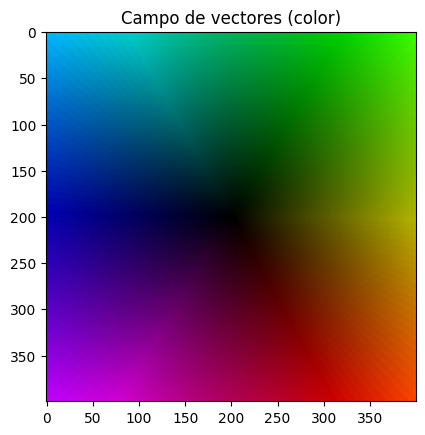

In [2]:
import cv2 as cv
import numpy as np

# Tamaño de la imagen
h, w = 400, 400

# Coordenadas (x, y)
x = np.arange(w)
y = np.arange(h)
xx, yy = np.meshgrid(x, y)

# Centro
cx, cy = w / 2, h / 2

# Vector desde el centro hasta cada píxel
dx = xx - cx
dy = yy - cy

# Magnitud proporcional a la distancia al centro
magnitude = np.sqrt(dx**2 + dy**2)

# Dirección opuesta al centro → invertir el vector
dx = -dx
dy = -dy

# Normalizar para que la magnitud sea manejable
max_mag = np.max(magnitude)
magnitude = magnitude / max_mag * 255  # escalar a 0–255
angle = np.arctan2(dy, dx)  # ángulo en radianes

# Convertir a imagen HSV para visualizar como flujo óptico
hsv = np.zeros((h, w, 3), dtype=np.uint8)
hsv[..., 0] = (angle * 180 / np.pi / 2) % 180   # tono → dirección
hsv[..., 1] = 255                               # saturación máxima
hsv[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)  # brillo → magnitud

# Convertir a BGR para mostrar
bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

plt.imshow(bgr)
plt.title("Campo de vectores (color)")
#plt.axis("off")
plt.show()



#cv.imshow('Campo de vectores (color)', bgr)
#cv.waitKey(0)
#cv.destroyAllWindows()


https://github.com/GerardoMunoz/Vision/blob/main/videos/20251008_120434.mp4

In [3]:
# ---------- Estimation methods ----------
def estimate_with_orb_and_affine(img1_gray, img2_gray, debug_draw=None):
    """
    Use ORB to match keypoints, then estimate affine (2x3) using RANSAC.
    Returns:
       M_affine (2x3) or None,
       matches_img (BGR) visualization,
       num_inliers
    """
    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)

    if des1 is None or des2 is None or len(kp1) < 4 or len(kp2) < 4:
        return None, None, 0

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    if len(matches) < 6:
        return None, None, 0

    # Keep top matches (tunable)
    top_matches = matches[:200]

    pts1 = np.float32([kp1[m.queryIdx].pt for m in top_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in top_matches])

    # estimate affine partial (scale+rotation+translation)
    M_affine, inliers = cv2.estimateAffinePartial2D(pts1, pts2, method=cv2.RANSAC, ransacReprojThreshold=3.0)

    # draw matches (only those considered)
    if debug_draw is None:
        # create color image for drawing
        vis = cv2.cvtColor(img2_gray, cv2.COLOR_GRAY2BGR)
    else:
        vis = debug_draw.copy()

    # draw first 30 matches
    match_img = cv2.drawMatches(cv2.cvtColor(img1_gray, cv2.COLOR_GRAY2BGR), kp1,
                                cv2.cvtColor(img2_gray, cv2.COLOR_GRAY2BGR), kp2,
                                top_matches[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    num_inliers = int(np.sum(inliers)) if inliers is not None else 0
    return M_affine, match_img, num_inliers

def estimate_with_orb_homography(img1_gray, img2_gray):
    """
    ORB + BF + findHomography (RANSAC).
    Return H (3x3) or None and matches visualization and number of inliers.
    """
    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)
    if des1 is None or des2 is None:
        return None, None, 0

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)
    # ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    if len(good) < 6:
        return None, None, 0

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 4.0)
    match_img = cv2.drawMatches(cv2.cvtColor(img1_gray, cv2.COLOR_GRAY2BGR), kp1,
                                cv2.cvtColor(img2_gray, cv2.COLOR_GRAY2BGR), kp2,
                                good[:30], None, matchesMask=(mask.ravel().tolist() if mask is not None else None),
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    inliers = int(np.sum(mask)) if mask is not None else 0
    return H, match_img, inliers

def estimate_with_lk(img1_gray, img2_gray, max_corners=500):
    """
    Use goodFeaturesToTrack on img1 and track with calcOpticalFlowPyrLK to img2.
    Estimate median translation and a rough rotation/scale via PCA on displacement vectors.
    Returns a dict with tx, ty, median_dx, median_dy, rotation_deg_est, scale_est, num_tracked.
    Also returns a visualization overlay of flow vectors.
    """
    feature_params = dict(maxCorners=max_corners, qualityLevel=0.01, minDistance=7, blockSize=7)
    p0 = cv2.goodFeaturesToTrack(img1_gray, mask=None, **feature_params)
    if p0 is None or len(p0) < 5:
        return None, None

    lk_params = dict(winSize=(21,21), maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)
    if p1 is None:
        return None, None

    good0 = p0[st==1]
    good1 = p1[st==1]
    if len(good0) < 4:
        return None, None

    displacements = good1 - good0
    dxs = displacements[:,0]
    dys = displacements[:,1]
    median_dx = np.median(dxs)
    median_dy = np.median(dys)

    # Rough rotation/scale: compute angle between vectors from centroid to points before/after
    c0 = np.mean(good0, axis=0)
    v0 = good0 - c0
    v1 = good1 - c0  # note using same center to get rotation and scale approx
    # Avoid degenerate
    norms0 = np.linalg.norm(v0, axis=1)
    norms1 = np.linalg.norm(v1, axis=1)
    valid = (norms0 > 1e-3) & (norms1 > 1e-3)
    if np.sum(valid) >= 3:
        angles0 = np.arctan2(v0[valid,1], v0[valid,0])
        angles1 = np.arctan2(v1[valid,1], v1[valid,0])
        angle_diffs = angles1 - angles0
        # Normalize angles to [-pi, pi]
        angle_diffs = (angle_diffs + np.pi) % (2*np.pi) - np.pi
        rotation_rad = np.median(angle_diffs)
        rotation_deg = math.degrees(rotation_rad)
        scale_est = np.median(norms1[valid] / norms0[valid])
    else:
        rotation_deg = 0.0
        scale_est = 1.0

    # visualize vectors on an RGB version of img2
    vis = cv2.cvtColor(img2_gray, cv2.COLOR_GRAY2BGR)
    for (x0,y0),(x1,y1) in zip(good0.reshape(-1,2), good1.reshape(-1,2)):
        cv2.arrowedLine(vis, (int(x0),int(y0)), (int(x1),int(y1)), (0,255,0), 1, tipLength=0.3)
    result = {
        "median_dx": float(median_dx),
        "median_dy": float(median_dy),
        "rotation_deg": float(rotation_deg),
        "scale": float(scale_est),
        "num_tracked": int(len(good0))
    }
    return result, vis

In [6]:
# ==========================================================
# Colab Video Frame Viewer + Transform Tool (OpenCV + Matplotlib)
# ==========================================================



# transformed=None
# frame=None
# # ---- Upload and open the video ----
# uploaded = files.upload()
# video_path = list(uploaded.keys())[0]

# cap = cv2.VideoCapture(video_path)
# if not cap.isOpened():
#     raise Exception('No se pudo abrir el video.')



Saving 20251008_120434.mp4 to 20251008_120434.mp4


In [7]:
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"✅ Video cargado: {video_path}")
print(f"Frames: {num_frames}, FPS: {fps:.2f}")

# ---- Function to extract a frame ----
def get_frame(index):
    global frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, frame = cap.read()
    if not ret:
        return None
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

# ---- Transformation function ----
def apply_transformations(frame, rot=0, scale=1.0, tx=0, ty=0,
                          blur=0, noise=False):
    global transformed
    h, w = frame.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, rot, scale)
    M[0,2] += tx
    M[1,2] += ty
    transformed = cv2.warpAffine(frame, M, (w, h),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REFLECT)
    if blur > 0:
        k = int(blur)
        if k % 2 == 0: k += 1
        transformed = cv2.GaussianBlur(transformed, (k, k), 0)
    if noise:
        noise_mat = np.random.normal(0, 12, transformed.shape).astype(np.float32)
        transformed = np.clip(transformed.astype(np.float32) + noise_mat, 0, 255).astype(np.uint8)
    return transformed

# ---- Interactive visualization ----
def show_frame(frame_idx=0, rot=0, scale=1.0, tx=0, ty=0, blur=0, noise=False):
    frame = get_frame(frame_idx)
    if frame is None:
        print("No se pudo leer el frame.")
        return
    transformed = apply_transformations(frame, rot, scale, tx, ty, blur, noise)
    # Show original + transformed
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(frame)
    axs[0].set_title(f"Frame {frame_idx}")
    axs[0].axis('off')
    axs[1].imshow(transformed)
    axs[1].set_title(f"Transformado (rot={rot}°, scale={scale:.2f})")
    axs[1].axis('off')
    plt.show()
    #return transformed

# ---- Create sliders ----
interact(
    show_frame,
    frame_idx=IntSlider(min=0, max=num_frames-1, step=1, value=0, description='Frame'),
    rot=IntSlider(min=-180, max=180, step=1, value=0, description='Rotación'),
    scale=FloatSlider(min=0.2, max=3.0, step=0.05, value=1.0, description='Escala'),
    tx=IntSlider(min=-200, max=200, step=1, value=3, description='Trans X'),
    ty=IntSlider(min=-200, max=200, step=1, value=5, description='Trans Y'),
    blur=IntSlider(min=0, max=25, step=1, value=0, description='Blur'),
    noise=Checkbox(value=False, description='Ruido')
);


✅ Video cargado: 20251008_120434.mp4
Frames: 314, FPS: 29.98


interactive(children=(IntSlider(value=0, description='Frame', max=313), IntSlider(value=0, description='Rotaci…

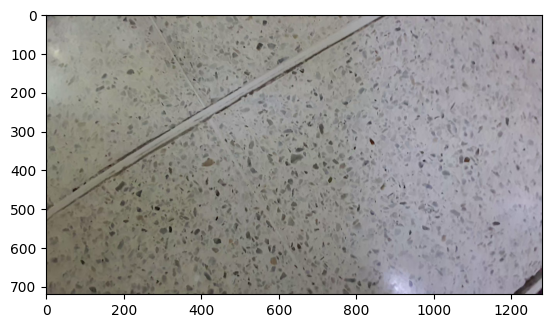

In [8]:
plt.imshow(get_frame(0))

In [9]:
frame.shape,  transformed.shape

((720, 1280, 3), (720, 1280, 3))

In [10]:
rows=slice(200,300)
cols=slice(600,700)

In [50]:

#img1_gray=cv2.cvtColor(get_frame(183)[rows,cols], cv2.COLOR_RGB2GRAY)#cv2.cvtColor(frame[rows,cols], cv2.COLOR_RGB2GRAY)
#img2_gray=cv2.cvtColor(get_frame(184)[rows,cols], cv2.COLOR_RGB2GRAY)#cv2.cvtColor(transformed[rows,cols], cv2.COLOR_RGB2GRAY)
img1_gray=cv2.resize(cv2.cvtColor(get_frame(183)[10:710,280:980], cv2.COLOR_RGB2GRAY),(100,100))#cv2.cvtColor(frame[rows,cols], cv2.COLOR_RGB2GRAY)
img2_gray=cv2.resize(cv2.cvtColor(get_frame(189)[10:710,280:980], cv2.COLOR_RGB2GRAY),(100,100))#cv2.cvtColor(transformed[rows,cols], cv2.COLOR_RGB2GRAY)


In [51]:
img1_gray.shape, img2_gray.shape

((100, 100), (100, 100))

In [52]:
def show_gray_images(show_img2=False):
    img_to_show = img2_gray if show_img2 else img1_gray
    plt.imshow(img_to_show, cmap='gray')
    plt.title('img2_gray' if show_img2 else 'img1_gray')
    plt.axis('off')
    plt.show()

interact(show_gray_images, show_img2=Checkbox(value=False, description='Show img2_gray'));

interactive(children=(Checkbox(value=False, description='Show img2_gray'), Output()), _dom_classes=('widget-in…

In [53]:
# Calcular flujo óptico Farneback
flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray, None,
                                   pyr_scale=0.5, levels=3, winsize=15,
                                   iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

# Separar componentes del flujo
fx, fy = flow[..., 0], flow[..., 1]

# Calcular magnitud y ángulo
magnitude, angle = cv2.cartToPolar(fx, fy)

# Crear visualización en color (HSV → BGR)
hsv = cv2.cvtColor(img1_gray, cv2.COLOR_GRAY2BGR)
hsv[..., 0] = angle * 180 / np.pi / 2   # tono
hsv[..., 1] = 255                       # saturación
hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
bgr_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)




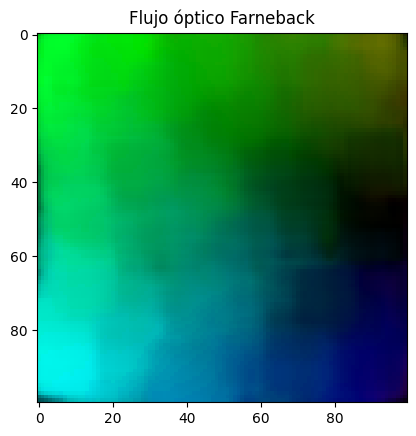

In [54]:
plt.imshow(bgr_flow)
plt.title("Flujo óptico Farneback")
#plt.axis("off")
plt.show()


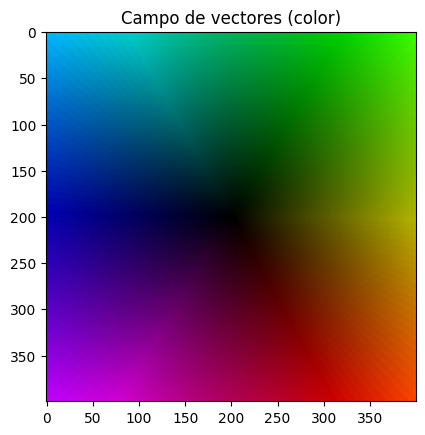

In [55]:

plt.imshow(bgr)
plt.title("Campo de vectores (color)")
#plt.axis("off")
plt.show()


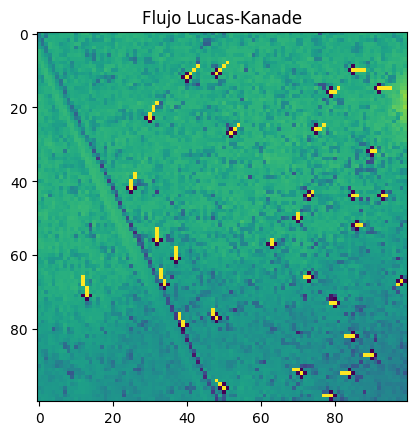

In [56]:
# Detectar puntos interesantes (esquinas) en la primera imagen
prev_pts = cv2.goodFeaturesToTrack(img1_gray,
                                  maxCorners=100,
                                  qualityLevel=0.3,
                                  minDistance=7,
                                  blockSize=7)

# Calcular el flujo óptico
next_pts, status, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, prev_pts, None)

# Filtrar puntos válidos
good_old = prev_pts[status == 1]
#print('good_old',good_old)
good_new = next_pts[status == 1]
#print('good_new',good_new)

# Dibujar el movimiento
mask = np.zeros_like(img1_gray)
img2 = img2_gray.copy()
for (new, old) in zip(good_new, good_old):
    a, b = new.ravel()
    #print(new,a,b)
    c, d = old.ravel()
    mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (255, 255, 255), 1)
    img2 = cv2.circle(img2, (int(a), int(b)), 1, (0, 0, 255), 0)

output = cv2.add(img2, mask)

# cv.imshow('Flujo Lucas-Kanade', output)
# cv.waitKey(0)
# cv.destroyAllWindows()
plt.imshow(output)#,cmap='gray'
plt.title("Flujo Lucas-Kanade")
#plt.axis("off")
plt.show()


In [57]:
interact(show_gray_images, show_img2=Checkbox(value=False, description='Show img2_gray'));

interactive(children=(Checkbox(value=False, description='Show img2_gray'), Output()), _dom_classes=('widget-in…